## Дипломная работа
### Этап 2: кластеризация

Импорт и установка (при необходимости) внешних библиотек 

In [1]:
import sys
!{sys.executable} -m pip install librosa

In [1]:
import warnings
import time
import os

warnings.simplefilter(action='ignore')

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import librosa
import sklearn

Пример с одним файлом

In [2]:
data_path = 'debug_data/'
x , sr = librosa.load(data_path + 'exhale_6.wav')

In [3]:
import IPython.display as ipd
ipd.Audio(data_path + 'exhale_6.wav')

Волна

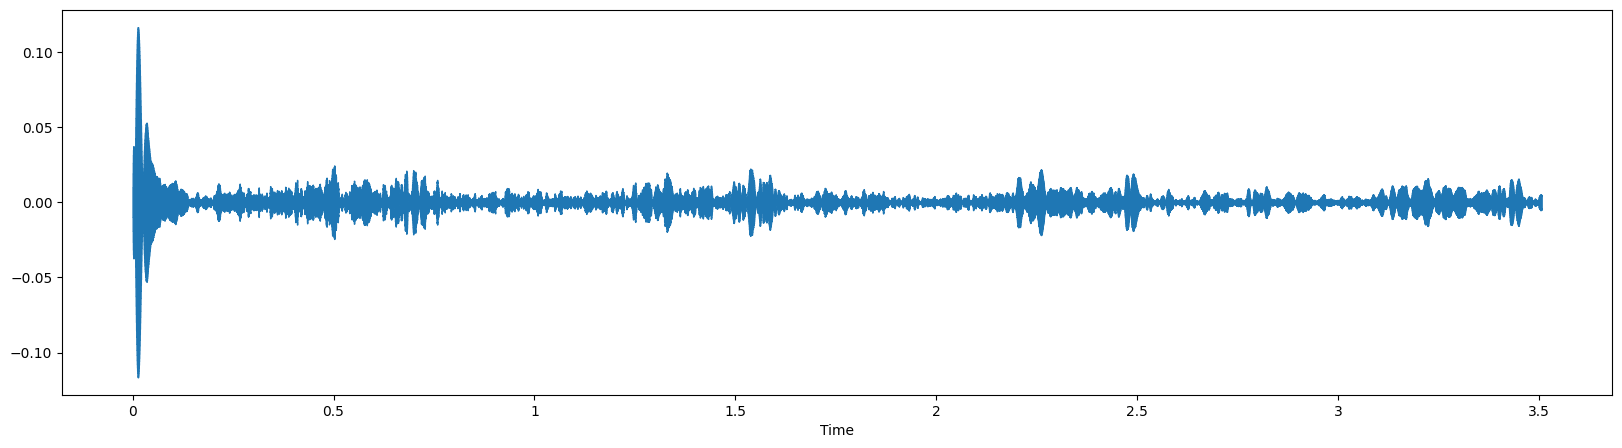

In [4]:
%matplotlib inline

plt.figure(figsize=(20, 5))
librosa.display.waveshow(x, sr=sr)

Спектрограмма

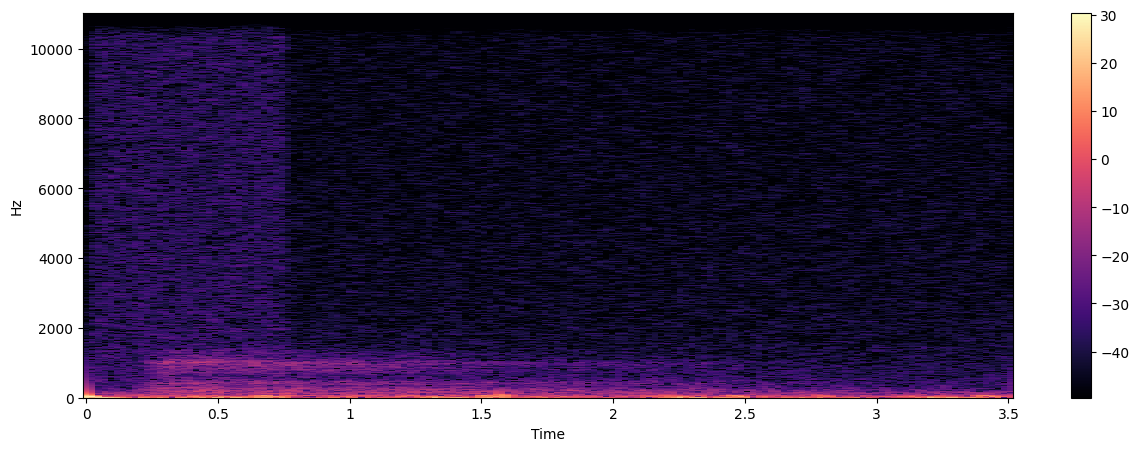

In [5]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(15, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar()

Zero Crossing Rate

График показывает зависимость амплитуды (change of air pressure) от времени

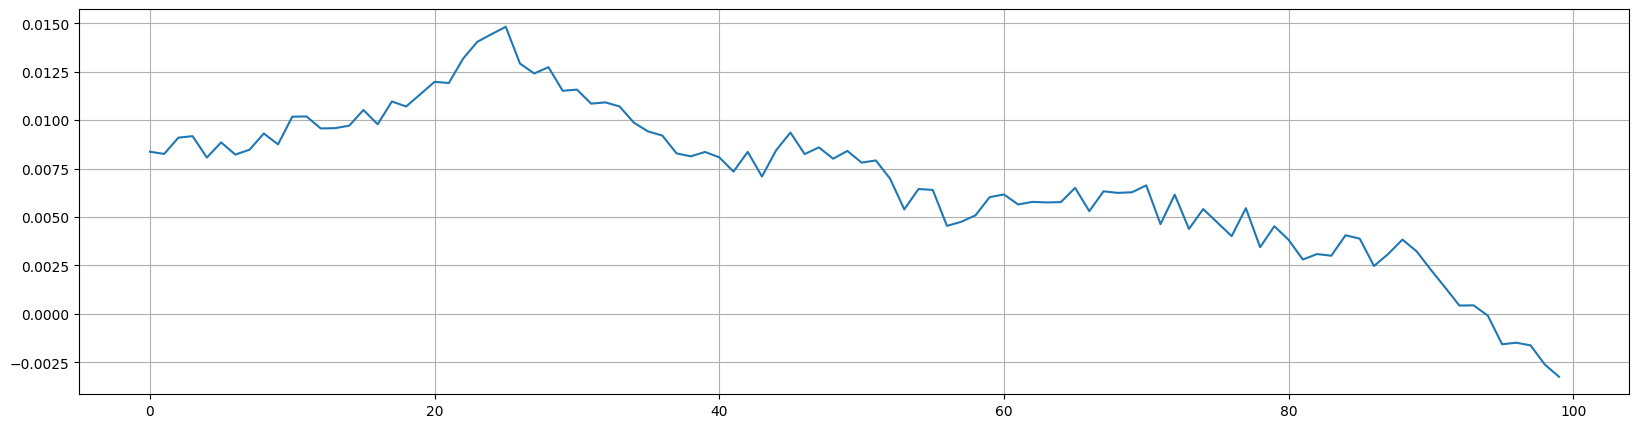

In [6]:
n0 = 9000
n1 = 9100
plt.figure(figsize=(20, 5))
plt.plot(x[n0:n1])
plt.grid()

### Обработка звука

In [7]:
from pydub.utils import get_array_type
from pydub import AudioSegment
from scipy.signal import butter, filtfilt

1. Нормализация громкости

In [8]:
def normalize_audio(input_file, output_file, target_dBFS=-15.0):
    # Load the audio file
    sound = AudioSegment.from_file(input_file)
    
    # Calculate the difference to target dBFS
    change_in_dBFS = target_dBFS - sound.dBFS
    
    # Apply normalization
    normalized_sound = sound.apply_gain(change_in_dBFS)
    
    # Export the normalized audio to a file
    normalized_sound.export(output_file, format="wav")
    # print(f"Audio normalized to {target_dBFS} dBFS and saved to {output_file}")


2. Применение эквалайзера

In [9]:
import scipy.io.wavfile as wavfile
from scipy.signal.windows import hann

def custom_equalizer(input_file, output_file):
    # Read audio file
    sample_rate, data = wavfile.read(input_file)

    # Handle stereo audio (convert to mono if needed)
    if len(data.shape) > 1:
        data = data.mean(axis=1).astype(data.dtype)

    # Apply a window function (Hann window)
    window = hann(len(data))
    windowed_data = data * window

    # Apply FFT (Fast Fourier Transform)
    freq_data = np.fft.rfft(windowed_data)  # Real FFT
    frequencies = np.fft.rfftfreq(len(data), d=1/sample_rate)

    # Define gain adjustments (example: boost low, cut mid, boost high)
    gain = np.ones_like(frequencies)
    gain[(frequencies >= 630) & (frequencies < 800)] *= 0.9 
    gain[(frequencies >= 800) & (frequencies < 1000)] *= 0.8
    gain[(frequencies >= 1000) & (frequencies < 2500)] *= 0.4
    gain[frequencies > 2500] *= 0  

    # Apply the gain to frequency data
    equalized_freq_data = freq_data * gain


    # Inverse FFT to get back to time domain
    equalized_audio = np.fft.irfft(equalized_freq_data).astype(data.dtype)
    
    # Normalize by window to compensate for amplitude scaling
    # equalized_audio = equalized_audio / window.max()  # Normalize gain applied by the window


    # Write the output file
    wavfile.write(output_file, sample_rate, equalized_audio)

3. Удаление шума

In [10]:
def noise_gate(audio_file, output_file, threshold_db=-6.0, level_reduction_db=-24.0, 
                     attack_ms=10, hold_ms=50, decay_ms=100):
    # Load the audio file
    audio = AudioSegment.from_file(audio_file)
    samples = np.array(audio.get_array_of_samples())
    sample_rate = audio.frame_rate
    sample_width = audio.sample_width
    channels = audio.channels
    
    # Convert attack, hold, and decay from ms to samples
    attack_samples = int(sample_rate * (attack_ms / 1000))
    hold_samples = int(sample_rate * (hold_ms / 1000))
    decay_samples = int(sample_rate * (decay_ms / 1000))
    
    # Threshold and level reduction in linear scale
    threshold_linear = 10 ** (threshold_db / 20)
    reduction_factor = 10 ** (level_reduction_db / 20)
    
    # Process samples
    envelope = 0  # Tracks signal envelope
    hold_counter = 0
    processed_samples = []
    
    for i, sample in enumerate(samples):
        amplitude = abs(sample) / (2 ** (8 * sample_width - 1))  # Normalize amplitude
        
        # Noise gate logic
        if amplitude > threshold_linear:
            envelope = max(envelope, amplitude)  # Update envelope
            hold_counter = hold_samples         # Reset hold counter
        else:
            if hold_counter > 0:
                hold_counter -= 1
            else:
                envelope -= (1 / decay_samples)  # Gradually reduce envelope
                envelope = max(envelope, 0)      # Prevent negative values
        
        # Apply attack smoothing
        if envelope > amplitude:
            amplitude = amplitude + (envelope - amplitude) / attack_samples
        
        # Apply level reduction if gated
        if envelope < threshold_linear:
            amplitude *= reduction_factor
        
        # Re-scale back to sample range
        processed_sample = int(amplitude * (2 ** (8 * sample_width - 1)))
        processed_samples.append(processed_sample)
    
    # Convert processed samples back to AudioSegment
    gated_audio = audio._spawn(np.array(processed_samples, dtype=np.int16).tobytes())
    gated_audio = gated_audio.set_frame_rate(sample_rate)
    
    # Save output audio
    gated_audio.export(output_file, format="wav")

# Альтернатива
def apply_low_pass_filter(audio_path, cutoff_freq, output_path):
    # Load audio
    audio = AudioSegment.from_file(audio_path)
    frame_rate = audio.frame_rate
    num_channels = audio.channels
    sample_width = audio.sample_width

    # Extract raw samples
    samples = np.array(audio.get_array_of_samples())
    
    # Handle stereo audio
    if num_channels == 2:
        samples = samples.reshape((-1, 2))
    
    # Normalize samples to range [-1, 1]
    max_val = float(2 ** (8 * sample_width - 1))
    samples = samples / max_val

    # Design low-pass filter
    nyquist = 0.5 * frame_rate
    normalized_cutoff = cutoff_freq / nyquist
    b, a = butter(4, normalized_cutoff, btype='low', analog=False)

    # Apply filter
    if num_channels == 2:
        # Process each channel independently
        filtered_samples = np.column_stack([
            filtfilt(b, a, samples[:, 0]),
            filtfilt(b, a, samples[:, 1])
        ])
    else:
        filtered_samples = filtfilt(b, a, samples)

    # Denormalize and convert to original data type
    filtered_samples = np.clip(filtered_samples * max_val, -max_val, max_val - 1).astype(np.int16)

    # Flatten stereo data for saving
    if num_channels == 2:
        filtered_samples = filtered_samples.flatten()

    # Create new AudioSegment
    filtered_audio = audio._spawn(filtered_samples.tobytes())
    filtered_audio.export(output_path, format="wav")

Применение всех настроек

In [11]:
import glob


parent_dir = 'debug_data/'
modified_dir = 'modified_data/'
wavs = glob.glob(parent_dir + '*.wav')
for song in wavs:
    # print(f"Boosting {song}...")
    wav = AudioSegment.from_wav(song)
    wav_cutout = wav # [750:]
    boosted_wav = wav_cutout + 10
    boosted_wav.export(modified_dir + song[11:], format='wav')

wavs = glob.glob(modified_dir + '*.wav')
for song in wavs:
    # print(f"Processing {song}...")
    noise_gate(song, song)
    # apply_low_pass_filter(song, 3500, song)
    normalize_audio(song, song)
    custom_equalizer(song, song)
    # remove_high_freq(song, song)
    

#### Посмотрим на визуализацию модифицированных данных

In [12]:
x , sr = librosa.load(modified_dir + 'exhale_6.wav')
ipd.Audio(modified_dir + 'exhale_6.wav')

Волна

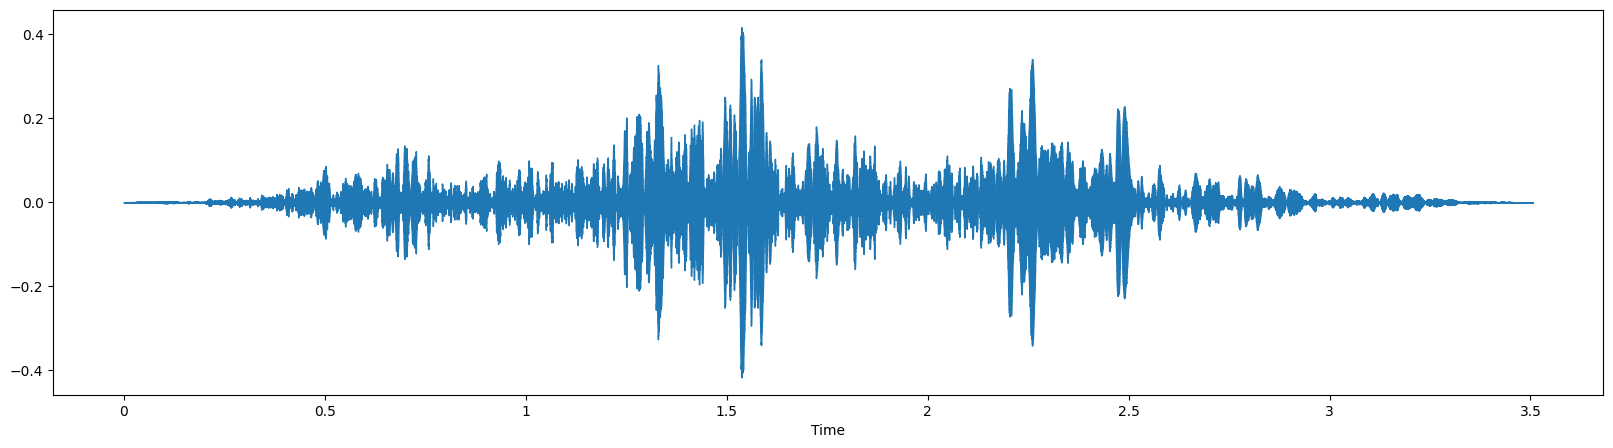

In [13]:
%matplotlib inline

plt.figure(figsize=(20, 5))
librosa.display.waveshow(x, sr=sr)

Спектрограмма

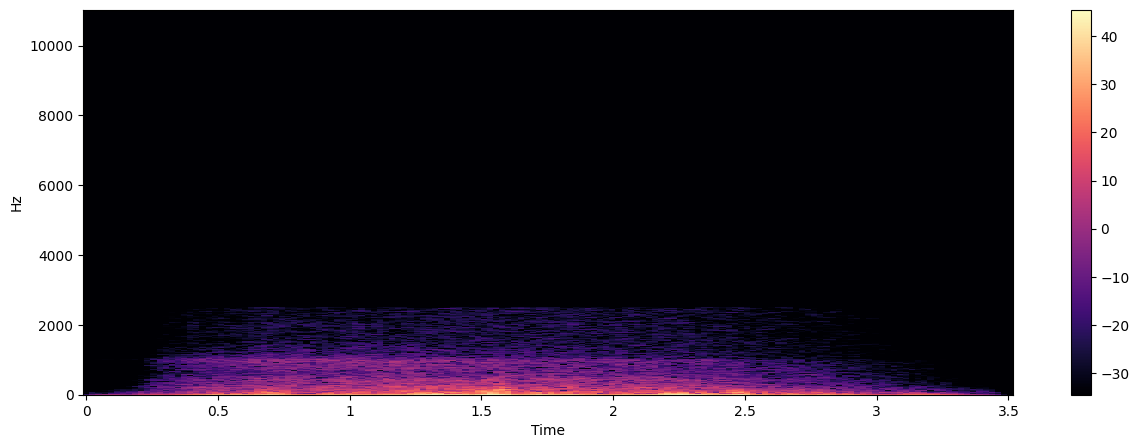

In [14]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(15, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar()

Zero Crossing Rate

График показывает зависимость амплитуды (change of air pressure) от времени

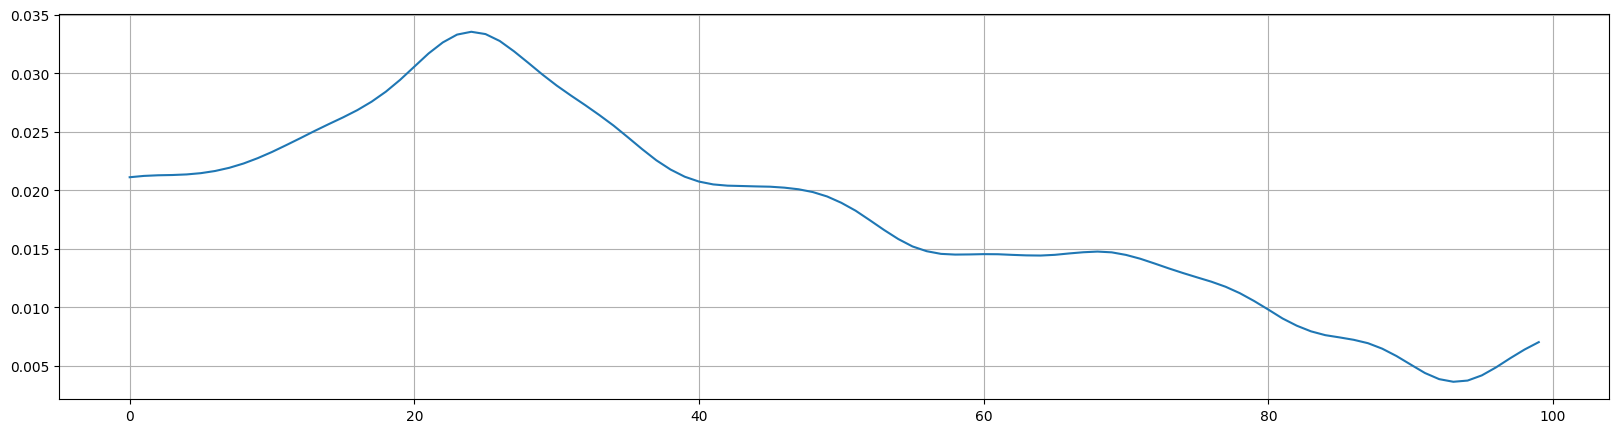

In [15]:
n0 = 9000
n1 = 9100
plt.figure(figsize=(20, 5))
plt.plot(x[n0:n1])
plt.grid()

### Соберем ShortTermFeatures

Исходный репозиторий : https://github.com/TylerMclaughlin/wav_clustering_workflow

In [17]:
from pyAudioAnalysis import ShortTermFeatures as aF
from pyAudioAnalysis import audioBasicIO as aIO 

def get_short_term_features(wav_loc, win = 0.050, step = 0.050):
    """ 
    Extract short-term features using default 50msec non-overlapping windows
    """

    # get sampling frequency and signal.
    fs, s = aIO.read_audio_file(wav_loc)
    # convert to mono so all features work!
    # s = aIO.stereo_to_mono(s) 

    # print duration of wav in seconds:
    duration = len(s) / float(fs)
    print(f'{wav_loc} duration = {duration} seconds')
    
    # features, feature names.
    # feature names look like ['zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12', 'chroma_std', 'delta zcr', 'delta energy', 'delta energy_entropy', 'delta spectral_centroid', 'delta spectral_spread', 'delta spectral_entropy', 'delta spectral_flux', 'delta spectral_rolloff', 'delta mfcc_1', 'delta mfcc_2', 'delta mfcc_3', 'delta mfcc_4', 'delta mfcc_5', 'delta mfcc_6', 'delta mfcc_7', 'delta mfcc_8', 'delta mfcc_9', 'delta mfcc_10', 'delta mfcc_11', 'delta mfcc_12', 'delta mfcc_13', 'delta chroma_1', 'delta chroma_2', 'delta chroma_3', 'delta chroma_4', 'delta chroma_5', 'delta chroma_6', 'delta chroma_7', 'delta chroma_8', 'delta chroma_9', 'delta chroma_10', 'delta chroma_11', 'delta chroma_12', 'delta chroma_std']
    # features f look like numpy matrices
    try:
        [f, fn] = aF.feature_extraction(s, fs, int(fs * win), int(fs * step))
        print(f'{f.shape[1]} frames, {f.shape[0]} short-term features')

        return [f, fn]
    # sometimes the feature extraction yields a ValueError because the sample is too short.
    except ValueError:
        print("ValueError")
        return None
    

def flatten_n_frames(f,n):
    m = f[:,:n]
    # use Fortran order so that [[1,2],[3,4],[5,6]] becomes [1,3,5,2,4,6] (i.e., adjacent frames first, then onto the next feature.)
    return m.flatten('F')

In [18]:
def get_features_frame(wav_locs, first_n_frames, include_file_name=False, include_parent_dir=False):
    """
    Iterates over the list of paths to each wav file of interest. Extracts feature matrix. Subsets the feature matrix to the first_n_frames.  

    include_parent_dir should be set to True if the parent directory of the sample contains meaningful information (like the drum machine, for instance).
    If this is the case, the new drum name will be like 'kicks/kd01.wav'.  I call this a 'dir_wav'.

    """
    feature_dict = {}
    for w in wav_locs:
        wav_basename = w.split('/')[-1]
        if include_parent_dir: # For plotting, make the name of the wav a 'dir_wav', e.g., 'dir_name/sample_name.wav'
            wav_dirname = w.split('/')[-2]
            wav_basename = wav_dirname + '/' + wav_basename
        try:
            f, fn = get_short_term_features(w, 0.05, 0.05)
            feature_dict[wav_basename] = flatten_n_frames(f, first_n_frames)
        except TypeError:
            print(f'{w} appears to be too short to extract features')
    features_wavs_df = pd.DataFrame.from_dict(feature_dict, orient='index').transpose()
    return features_wavs_df 

In [19]:
import glob

# cur_dir = "Dyspnea"
wavs = glob.glob(modified_dir + '*.wav')
# wavs = glob.glob(f'web_recordings/{cur_dir}/audio/*.wav')
df_ward = get_features_frame(wavs, 2)
# df_ward.to_csv(f"web_recordings/{cur_dir}/{cur_dir}_short_term_features.csv")
df_kmeans = get_features_frame(wavs, 4)

modified_data/exhale_75.wav duration = 2.507755102040816 seconds
50 frames, 68 short-term features
modified_data/exhale_61.wav duration = 1.811156462585034 seconds
36 frames, 68 short-term features
modified_data/exhale_49.wav duration = 2.36843537414966 seconds
47 frames, 68 short-term features
modified_data/inhale_48.wav duration = 2.2987755102040817 seconds
45 frames, 68 short-term features
modified_data/inhale_74.wav duration = 2.089795918367347 seconds
41 frames, 68 short-term features
modified_data/inhale_60.wav duration = 1.9504761904761905 seconds
39 frames, 68 short-term features
modified_data/inhale_61.wav duration = 1.9272562358276644 seconds
38 frames, 68 short-term features
modified_data/inhale_75.wav duration = 2.6006349206349206 seconds
52 frames, 68 short-term features
modified_data/inhale_49.wav duration = 1.6253968253968254 seconds
32 frames, 68 short-term features
modified_data/exhale_48.wav duration = 2.2058956916099772 seconds
44 frames, 68 short-term features
modif

In [10]:
# df_ward.to_csv("values_ward.csv")
df_ward.to_csv("web_recordings/Standing/Standing_short_term_features.csv")


In [20]:
df_ward.head(5)

,exhale_75.wav,exhale_61.wav,exhale_49.wav,inhale_48.wav,inhale_74.wav,inhale_60.wav,inhale_61.wav,inhale_75.wav,inhale_49.wav,exhale_48.wav,...,inhale_87.wav,inhale_86.wav,inhale_79.wav,inhale_45.wav,inhale_51.wav,inhale_1.wav,exhale_87.wav,exhale_44.wav,exhale_50.wav,exhale_78.wav
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.011286,0.017677,0.001970,0.020349,0.007470,0.018432,0.013443,0.015781,0.020347,0.015897,...,0.013901,0.015784,0.016508,0.028806,0.029351,0.021596,0.010896,0.017373,0.021533,0.009712
2,3.317628,3.317233,3.317648,3.317675,3.317604,3.316060,3.317532,3.317562,3.317594,3.317667,...,3.317362,3.317320,3.316352,3.317654,3.317633,3.317603,3.317671,3.317560,3.317616,3.317462
3,0.004234,0.006132,0.003088,0.003654,0.004445,0.015162,0.005989,0.005285,0.004791,0.003185,...,0.003532,0.008925,0.011408,0.002686,0.005031,0.004564,0.003518,0.003683,0.001819,0.002161
4,0.042135,0.052730,0.034609,0.038952,0.043470,0.086377,0.052039,0.048339,0.045536,0.034929,...,0.037461,0.065133,0.074402,0.030889,0.047680,0.044203,0.037460,0.038547,0.022157,0.026125


Иерархическая кластеризация

In [21]:
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list
from scipy.spatial.distance import pdist

df_ward.fillna(0, inplace=True)
feature_matrix = df_ward.T.values # n dimensional, m observations.
Z = ward(pdist(feature_matrix))
ll = list(leaves_list(Z))
breathe_moment = df_ward.columns[ll]
list_of_dir_wavs = [x for x in df_ward.columns]
dn = dendrogram(Z, labels = list_of_dir_wavs, orientation = 'left')
plt.savefig('dendrogram_ward.png')
plt.close()

K-means

In [22]:
from scipy.cluster.vq import kmeans2

df_kmeans.fillna(0, inplace=True)
feature_matrix = df_kmeans.T.values
centroid, label = kmeans2(
    data=feature_matrix,
    k=2
)

counts = np.bincount(label)
counts

array([89, 91])

In [23]:
kmeans_result = pd.DataFrame({"class": label, "name": df_kmeans.columns})
kmeans_result

,class,name
0,1,exhale_75.wav
1,0,exhale_61.wav
2,1,exhale_49.wav
3,1,inhale_48.wav
4,1,inhale_74.wav
...,...,...
175,1,inhale_1.wav
176,0,exhale_87.wav
177,1,exhale_44.wav
178,0,exhale_50.wav


In [456]:
kmeans_result["name"] = kmeans_result["name"].str[:6]
count_df = kmeans_result.groupby(["class", "name"]).size().reset_index(name='count')
count_df

,class,name,count
0,0,exhale,76
1,0,inhale,74
2,1,exhale,14
3,1,inhale,16


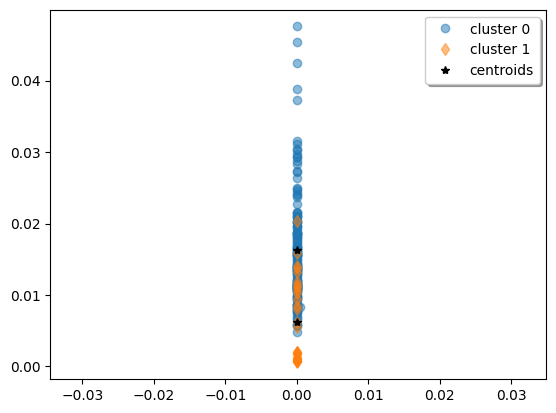

In [457]:
w0 = feature_matrix[label == 0]
w1 = feature_matrix[label == 1]
plt.plot(w0[:, 0], w0[:, 1], 'o', alpha=0.5, label='cluster 0')
plt.plot(w1[:, 0], w1[:, 1], 'd', alpha=0.5, label='cluster 1')
plt.plot(centroid[:, 0], centroid[:, 1], 'k*', label='centroids')
plt.axis('equal')
plt.legend(shadow=True)
plt.show()

### Классификация

In [24]:
df_classification = get_features_frame(wavs, 1).transpose()

modified_data/exhale_75.wav duration = 2.507755102040816 seconds
50 frames, 68 short-term features
modified_data/exhale_61.wav duration = 1.811156462585034 seconds
36 frames, 68 short-term features
modified_data/exhale_49.wav duration = 2.36843537414966 seconds
47 frames, 68 short-term features
modified_data/inhale_48.wav duration = 2.2987755102040817 seconds
45 frames, 68 short-term features
modified_data/inhale_74.wav duration = 2.089795918367347 seconds
41 frames, 68 short-term features
modified_data/inhale_60.wav duration = 1.9504761904761905 seconds
39 frames, 68 short-term features
modified_data/inhale_61.wav duration = 1.9272562358276644 seconds
38 frames, 68 short-term features
modified_data/inhale_75.wav duration = 2.6006349206349206 seconds
52 frames, 68 short-term features
modified_data/inhale_49.wav duration = 1.6253968253968254 seconds
32 frames, 68 short-term features
modified_data/exhale_48.wav duration = 2.2058956916099772 seconds
44 frames, 68 short-term features
modif

In [25]:
df_classification.to_csv("Parameters_classification.csv")

In [26]:
for dropped_columns in [0, 6, 7]:
    df_classification = df_classification.drop(dropped_columns, axis=1)

for dropped_columns in range(21, 33):
    df_classification = df_classification.drop(dropped_columns, axis=1)

# for dropped_columns in range(21 + 68, 33 + 68):
#     df_classification = df_classification.drop(dropped_columns, axis=1)

for dropped_columns in range(34, 68):
    df_classification = df_classification.drop(dropped_columns, axis=1)

In [27]:
df_classification["class"] = df_classification.index
exhale = df_classification['class'].str.startswith('ex')
inhale = df_classification['class'].str.startswith('in')
df_classification.loc[exhale,'class'] = True
df_classification.loc[inhale,'class'] = False
df_classification

,1,2,3,4,5,8,9,10,11,12,13,14,15,16,17,18,19,20,33,class
exhale_75.wav,0.011286,3.317628,0.004234,0.042135,2.345316e-06,-40.432991,2.461407,0.190591,0.424636,0.332571,0.283823,0.067911,0.178423,-0.021173,0.028638,0.053176,0.201115,-0.104418,0.046063,True
exhale_61.wav,0.017677,3.317233,0.006132,0.052730,5.406574e-06,-38.646120,2.346223,0.255593,0.455965,0.153224,0.188719,0.084445,0.220191,0.084397,0.077894,0.003914,0.114123,0.100096,0.046059,True
exhale_49.wav,0.001970,3.317648,0.003088,0.034609,1.539844e-06,-46.457322,0.422198,-0.426666,0.363620,1.014750,0.499593,-0.269711,0.265747,0.150198,0.241797,0.215074,0.259210,-0.208971,0.046064,True
inhale_48.wav,0.020349,3.317675,0.003654,0.038952,1.679541e-06,-40.771878,1.959322,0.142597,0.561483,0.202302,0.065896,0.181464,0.247010,-0.026768,0.034691,0.178999,0.041683,-0.163778,0.046064,False
inhale_74.wav,0.007470,3.317604,0.004445,0.043470,2.465614e-06,-40.971549,2.321001,0.205937,0.482849,0.178414,0.173581,0.054158,0.086149,0.039622,0.108362,0.057515,0.021022,0.001094,0.046063,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
inhale_1.wav,0.021596,3.317603,0.004564,0.044203,2.657863e-06,-39.343985,2.411172,0.236117,0.461327,0.223197,0.190326,0.049800,0.166209,0.031557,0.048299,0.046076,0.102645,0.072497,0.046063,False
exhale_87.wav,0.010896,3.317671,0.003518,0.037460,1.384730e-06,-41.142497,2.419593,-0.032352,0.287297,0.245190,0.273673,-0.040252,0.058719,0.045733,0.026056,-0.025792,0.119026,0.080682,0.046064,True
exhale_44.wav,0.017373,3.317560,0.003683,0.038547,1.550499e-06,-40.432903,2.425041,0.228088,0.455177,0.217094,0.213292,0.117075,0.181967,0.109724,0.068187,0.003124,0.040846,-0.001938,0.046062,True
exhale_50.wav,0.021533,3.317616,0.001819,0.022157,2.071796e-07,-43.441154,2.443508,0.393874,0.750708,0.503357,0.347984,-0.122283,-0.066389,-0.043882,-0.090722,-0.068783,0.195982,0.125925,0.046064,True


In [28]:
y = df_classification['class']
y.index = [x for x in range(y.shape[0])]
df = df_classification.drop('class', axis=1)
X = pd.DataFrame(df, index = df.index, columns = df.columns)
X.index = [x for x in range(X.shape[0])]
X

,1,2,3,4,5,8,9,10,11,12,13,14,15,16,17,18,19,20,33
0,0.011286,3.317628,0.004234,0.042135,2.345316e-06,-40.432991,2.461407,0.190591,0.424636,0.332571,0.283823,0.067911,0.178423,-0.021173,0.028638,0.053176,0.201115,-0.104418,0.046063
1,0.017677,3.317233,0.006132,0.052730,5.406574e-06,-38.646120,2.346223,0.255593,0.455965,0.153224,0.188719,0.084445,0.220191,0.084397,0.077894,0.003914,0.114123,0.100096,0.046059
2,0.001970,3.317648,0.003088,0.034609,1.539844e-06,-46.457322,0.422198,-0.426666,0.363620,1.014750,0.499593,-0.269711,0.265747,0.150198,0.241797,0.215074,0.259210,-0.208971,0.046064
3,0.020349,3.317675,0.003654,0.038952,1.679541e-06,-40.771878,1.959322,0.142597,0.561483,0.202302,0.065896,0.181464,0.247010,-0.026768,0.034691,0.178999,0.041683,-0.163778,0.046064
4,0.007470,3.317604,0.004445,0.043470,2.465614e-06,-40.971549,2.321001,0.205937,0.482849,0.178414,0.173581,0.054158,0.086149,0.039622,0.108362,0.057515,0.021022,0.001094,0.046063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.021596,3.317603,0.004564,0.044203,2.657863e-06,-39.343985,2.411172,0.236117,0.461327,0.223197,0.190326,0.049800,0.166209,0.031557,0.048299,0.046076,0.102645,0.072497,0.046063
176,0.010896,3.317671,0.003518,0.037460,1.384730e-06,-41.142497,2.419593,-0.032352,0.287297,0.245190,0.273673,-0.040252,0.058719,0.045733,0.026056,-0.025792,0.119026,0.080682,0.046064
177,0.017373,3.317560,0.003683,0.038547,1.550499e-06,-40.432903,2.425041,0.228088,0.455177,0.217094,0.213292,0.117075,0.181967,0.109724,0.068187,0.003124,0.040846,-0.001938,0.046062
178,0.021533,3.317616,0.001819,0.022157,2.071796e-07,-43.441154,2.443508,0.393874,0.750708,0.503357,0.347984,-0.122283,-0.066389,-0.043882,-0.090722,-0.068783,0.195982,0.125925,0.046064


In [29]:
y = pd.DataFrame([int(x) for x in y])
y

,0
0,1
1,1
2,1
3,0
4,0
...,...
175,0
176,1
177,1
178,1


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)

KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

model_knn = KNeighborsClassifier()
# define grid search
grid = {'n_neighbors': [i for i in range(3, 16, 2)],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'manhattan', 'euclidean']}
start_time_knn = time.time()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
grid_search = GridSearchCV(estimator=model_knn, param_grid=grid, cv=cv)
grid_result_knn = grid_search.fit(X_train, y_train)
end_time_knn = time.time()
print("Best: %f using %s" % (grid_result_knn.best_score_, grid_result_knn.best_params_))
means = grid_result_knn.cv_results_['mean_test_score']
stds = grid_result_knn.cv_results_['std_test_score']
params = grid_result_knn.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
elapsed_time_knn = end_time_knn - start_time_knn
print("\nTime: {:.2f} seconds".format(elapsed_time_knn))

Best: 0.509630 using {'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'distance'}
0.497037 (0.093430) with: {'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'uniform'}
0.509630 (0.089981) with: {'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'distance'}
0.451111 (0.068968) with: {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'uniform'}
0.468889 (0.075399) with: {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
0.444444 (0.067077) with: {'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'uniform'}
0.448148 (0.084213) with: {'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'distance'}
0.431852 (0.100372) with: {'metric': 'minkowski', 'n_neighbors': 9, 'weights': 'uniform'}
0.432593 (0.088095) with: {'metric': 'minkowski', 'n_neighbors': 9, 'weights': 'distance'}
0.446667 (0.078186) with: {'metric': 'minkowski', 'n_neighbors': 11, 'weights': 'uniform'}
0.452593 (0.079880) with: {'metric': 'minkowski', 'n_neighbors': 11, 'weights': 'distance'}
0.47259

In [32]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve


model_knn.set_params(**grid_result_knn.best_params_)
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)
accuracy_score(y_test, y_pred_knn)

0.5333333333333333

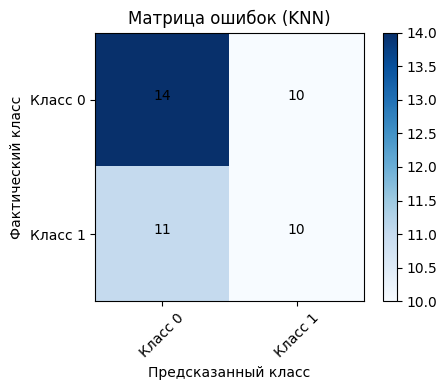

In [33]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(5, 4))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Матрица ошибок (KNN)')
plt.colorbar()

classes = ['Класс 0', 'Класс 1']
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(confusion[i][j]), horizontalalignment='center', color='black')

plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.tight_layout()
plt.grid(False)
plt.show()

SVM

In [34]:
from sklearn.svm import SVC

model_svm = SVC()
grid = {'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']}
start_time_svm = time.time()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
grid_search = GridSearchCV(estimator=model_svm, param_grid=grid, cv=cv)
grid_result_svm = grid_search.fit(X_train, y_train)
end_time_svm = time.time()
print("Best: %f using %s" % (grid_result_svm.best_score_, grid_result_svm.best_params_))
means = grid_result_svm.cv_results_['mean_test_score']
stds = grid_result_svm.cv_results_['std_test_score']
params = grid_result_svm.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
elapsed_time_svm = end_time_svm - start_time_svm
print("\nTime: {:.2f} seconds".format(elapsed_time_svm))

Best: 0.607875 using {'C': 10, 'gamma': 'auto', 'kernel': 'poly'}
0.543590 (0.069904) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
0.511538 (0.024627) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.511538 (0.024627) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.543590 (0.069904) with: {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
0.511538 (0.024627) with: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
0.568681 (0.108580) with: {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
0.567949 (0.108289) with: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.511538 (0.024627) with: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.511538 (0.024627) with: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
0.567949 (0.108289) with: {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
0.484066 (0.129864) with: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.607692 (0.128690) with: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
0.550549 (0.109729) with: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'

In [35]:
model_svm.set_params(**grid_result_svm.best_params_)
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)
accuracy_score(y_test, y_pred_svm)

0.6888888888888889

In [36]:
import joblib

joblib.dump(model_svm, "model_svm.pkm")

['model_svm.pkm']

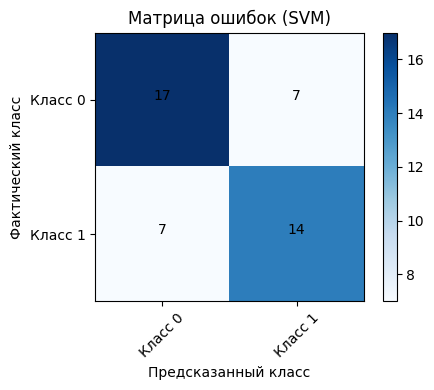

In [474]:
confusion = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(5, 4))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Матрица ошибок (SVM)')
plt.colorbar()

classes = ['Класс 0', 'Класс 1']
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(confusion[i][j]), horizontalalignment='center', color='black')

plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.tight_layout()
plt.grid(False)
plt.show()

In [475]:
print(classification_report(y_test, y_pred_svm))
print(f'ROC AUC score: {roc_auc_score(y_test, y_pred_svm)}')

              precision    recall  f1-score   support

           0       0.71      0.71      0.71        24
           1       0.67      0.67      0.67        21

    accuracy                           0.69        45
   macro avg       0.69      0.69      0.69        45
weighted avg       0.69      0.69      0.69        45

ROC AUC score: 0.6874999999999999
